# **Trabalho de Ciência dos Dados: Análise de países**
*Guilherme de Mello Ferreira*

**País desevolvido é país sem pobreza?**


Há o senso comum que um país desenvolvido é necessariamente rico. Pode-se dizer que esta afirmação está correta, porém em uma análise superficial. Uma simples pergunta já seria o bastante para quebrar a linha de racicínio desse pensamento inicial: *o que torna um país rico?* Algumas teorias já foram colocadas para tentar solver essa questão, como por exemplo, a campanha do Governo Federal Brasileiro durante os anos de mandato da ex-presidente Dilma Rousseff: "*país rico é país sem pobreza.*" que foi bastante contextada por parecer redundante. Porém, essa redundância existe de fato? Este trabalho propõe uma análise dessa situação, trazendo dados da desigualdade social presente em todo o mundo e mostrando se o IDH é de fato alterado por ela ou se as anomalias muito presentes na própria desigualdade são fundamentais para a elevação/queda do mesmo. Afinal, um país desenvolvido é um país sem pobreza? 

Para responder a essa pergunta, foram criados dois índices a partir dos dados existentes: o primeiro a ser considerado, leva em conta o PIB *per capta*, a razão de bilionários por 1 milhão e a porcentagem da população que vive com menos de 1,25 USD por dia. O segundo, relaciona todos esses fatores com o índice de GINI, vendo a distribuição desse PIB contando suas desigualdades, de modo que: $S = \frac {PIB}{GINI}$, e comparando-a com os outros fatores.

Para iniciar a programação, importam-se as bibliotecas que serão utilizadas no processo:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math as math
from scipy import stats
import matplotlib.pyplot as plt

A seguir, lê-se os arquivos inicialmente em Excel, com os dados retirados do Gapminder, em ordem: IDH, índice Gini, PIB *per capta*, número de bilionários por 1M habitantes e percentual de pobreza.

In [2]:
dadosidh = pd.read_excel ('IDH.xlsx')
dadosgini = pd.read_excel ('gini.xlsx')
dadospib = pd.read_excel ('per capta.xlsx')
dadosbilionarios = pd.read_excel ('Bilionários.xlsx')
dadospobreza = pd.read_excel ('pobreza.xlsx')

Com isso, separa-se as colunas que representam o ano que será analisado, no caso, $2007$.

In [3]:
idh = dadosidh.loc[:,["HDI",2007]]
gini = dadosgini.loc [:,[2007]]
pib = dadospib.loc[:,[2007]]
bilionarios = dadosbilionarios.loc[:,[2007]]
pobreza = dadospobreza.loc[:,[2007]]

Em seguida, junta-se as três tabelas que comporão a primeira análise, que são: IDH, PIB *per capta* bilionários por milhão e pobreza

In [4]:
tabela = idh.join(pib, how ="inner", rsuffix=' PIB', lsuffix=' IDH')
tabela = tabela.join(bilionarios, how ="inner", rsuffix=' bi', lsuffix=' PIB')
tabela = tabela.join(pobreza, how ="inner", rsuffix=' pobres', lsuffix=' bi')

E retira-se os países que contém campos em branco, deixando a tabela mais limpa.

In [5]:
tabela.dropna()
tabela.columns = tabela.columns = ['País', 'IDH', 'PIB', 'Bilionários', 'Pobres']

As primeiras análises sairão dessa tabela, sem considerar o índice Gini. A seguir, insere-se na tabela tal índice, para fazer uma segunda análise.

Text(0.5,1,'Relação IDH x Pib per capta')

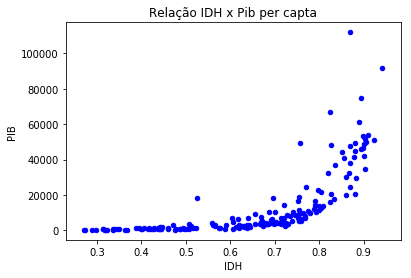

In [6]:
tabela.plot.scatter(x = "IDH", y = "PIB", color ='blue')
plt.title ('Relação IDH x Pib per capta')

Como podemos facilmente observar, existe uma clara correlação entre IDH e Pib *per capta* entre os países analisados, de forma aparentemente quase exponencial. Isso se dá pelo fato de que a renda é um dos fatores principais para o cálculo do IDH.

Agora vamos analisar o perfil dos dados relacionados à quantidade de bilionários por 1 milhão de pessoas: primeiramente, vê-se se existem anomalias muito grandes, e o motivo dessas anomalias, como um processo histórico que levou um país a ter mais bilionários por milhão. Para isso, plotar-se-á um Boxplot, que comparado com os dados mostrados pela função *describe* mostram se tais desigualdades existem.

count    258.000000
mean       0.249724
std        1.972028
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       30.608185
Name: Bilionários, dtype: float64

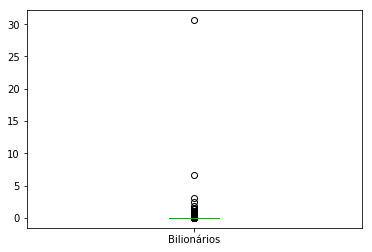

In [7]:
tabela.Bilionários.plot.box()
tabela.Bilionários.describe()

Podemos observar que a tabela de bilionários é repleta de anomalias, Uma vez que a maioria dos países não possui nenhuma pessoa nessa condição. As duas principais anomalias se tratam de Mônaco (com aproximadamente 30,6 bilionários por milhão de habitantes), pois o principado é conhecido por atrair grande fluxo de pessoas com muito dinheiro, devido aos seus casinos e aos setores imobiliário, que é muito forte em venda de imóveis de luxo, com muitas construtoras, e financeiro, uma vez que o país pe um paraíso fiscal, atraíndo grandes investidores; e Islândia, um país de cunho liberal, o que proporcionou um grande investimento externo no país, gerando um grande fluxo de dinheiro e enriquecimento rápido de um número relativamente grande de pessoas, considerando a população total do país (pouco mais de 300 000 habitantes).

Pelo _describe_ também podemos fazer uma primeira conclusão, bastante óbvia: mais de 75% dos países não possuem um bilionário sequer, chegando à uma primeira pergunta prévia: _Os países que possuem bilionários são, de fato, os mais desenvolvidos?_ Para respondê-la, fazer-se-á um isolamento dos países que possuem bilionários, excluíndo a maior anomalia: Mônaco. A Islândia não será retirada, pois sua população é considerável. 

Agora, vamos analisar os países que possuem bilionários. Primeiramente, retiramos todos aqueles que não possuem da tabela:

In [8]:
a = tabela[tabela.Bilionários>0]

A seguir, faz-se uma tabela cruzada com os dados, primeiramente dividindo o IDH em 10 faixas. Como o número de Bilionários por milhão é geralmente pequeno, e o objetivo é apenas ver a quantidade de países com bilionários para cada faixa de IDH, será criada apenas uma faixa de Bilionários, ou seja, uma informação booleana: Tem ou não tem.

In [9]:
tabela["IDHBAR"] = pd.cut(tabela['IDH'], bins=10)
tabela['BilionáriosBar'] = pd.cut (a['Bilionários'], bins = 1)
cruzada = pd.crosstab(tabela["IDHBAR"], tabela["BilionáriosBar"])
cruzada

BilionáriosBar,"(-0.0217, 30.608]"
IDHBAR,
"(0.27, 0.338]",0
"(0.338, 0.405]",0
"(0.405, 0.472]",0
"(0.472, 0.539]",1
"(0.539, 0.606]",2
"(0.606, 0.674]",4
"(0.674, 0.741]",8
"(0.741, 0.808]",11
"(0.808, 0.875]",9


A seguir, plotemos um gráfico com os dados dessa tabela:

Text(0.5,1,'Países com bilionários')

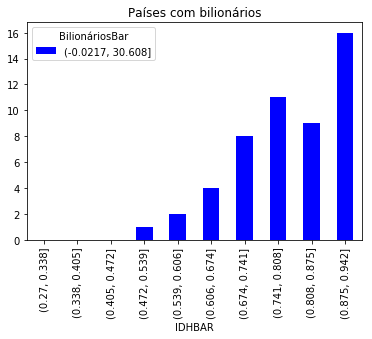

In [10]:
cruzada.plot.bar(color='b', legend = 'Países com Bilionários')
plt.title('Países com bilionários')

Pela análise da tabela e do gráfico, parece razoável supor que quanto mais desenvolvido um país é, maior a propensão a este possuir pelo menos um bilionário. Essa é a primeira conclusão parcial que a análise de dados nos levou e que servirá para ajudar a estabelecer uma hipótese válida pra responder a pergunta final. 

Faze-se o mesmo para o percentual de pobres.

count    55.000000
mean      1.467721
std       4.091085
min       0.000000
25%       0.017800
50%       0.128000
75%       1.060000
max      27.900000
Name: Pobres, dtype: float64

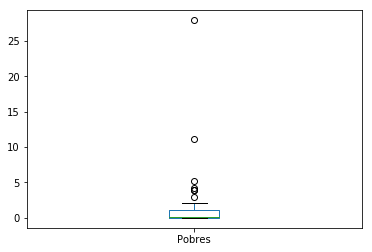

In [11]:
tabela.Pobres.plot.box()
tabela.Pobres.describe()

Novamente vemos duas anomalias bastante claras: Tanzânia (com aproximadamente 27,9% da população recebendo menos de 1,25 USD por dia), devido à questões antigas, como resultado de processos problemáticos em seu passado, como vários outros países do continente africano,  e Brasil, que na época estava com pouco mais de 11% de sua população vivendo em situação de pobreza. A primeira iteração, levou a pensar que essa questão se dá devido à desvalorização da moeda brasileira, que na época foi de, no ponto mais alto, aproximadamente 2,30$\frac {BRL}{USD}$. Considerando que o salário mínimo brasileiro era de aproximadamente 12,67 BRL por dia, o que dá aproximadamente 5,50 USD por dia. Isso nos leva a uma conclusão de que no Brasil, mais de 11% da população vivia abaixo do mínimo estabelecido por lei. Porém, isso ainda não leva à uma hipotese concreta do porquê da anomalia brasileira. Uma possível hipótese está dada na tranasição economica que o Brasil passava desde o final dos anos 1990, com o plano Real, estabelecido em 1994 e as políticas sociais do governo Lula, que diminuiram a pobreza, que estava em cerca de 24,0% no início da década (in: dadospobreza), fruto da desvalorização exarcebada na moeda e na economia, rescaldo da Ditadura militar e das políticas da década de 1980 que elevaram a inflação a níveis astronômicos.

In [12]:
g = tabela[tabela.Pobres>0]

In [13]:
tabela["IDHBAR"] = pd.cut(tabela['IDH'], bins=10)
tabela['Pobresbar'] = pd.cut (g['Pobres'], bins = 1)
cruzada1 = pd.crosstab(tabela["IDHBAR"], tabela["Pobresbar"])
cruzada1

Pobresbar,"(-0.0277, 27.9]"
IDHBAR,
"(0.27, 0.338]",2
"(0.338, 0.405]",0
"(0.405, 0.472]",2
"(0.472, 0.539]",3
"(0.539, 0.606]",4
"(0.606, 0.674]",7
"(0.674, 0.741]",11
"(0.741, 0.808]",9
"(0.808, 0.875]",4


Text(0.5,1,'Países com percentual de pobreza')

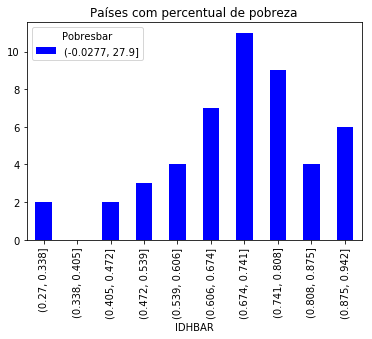

In [14]:
cruzada1.plot.bar(color = 'b')
plt.title('Países com percentual de pobreza')

Podemos observar nessa tabela, que o desenvolvimento de um país não se dá necessariamente pela falta de pobreza: temos pessoas vivendo com menos de 1,25 USD por dia em todas as faixas de IDH, não sendo algo exclusivo dos IDHs mais baixos. Essa é a segunda conclusão parcial.

E o que se pode afirmar sobre os países que possuem um índice de pobreza 0%?

In [15]:
m = tabela[tabela.Pobres==0]
m

,País,IDH,PIB,Bilionários,Pobres,IDHBAR,BilionáriosBar,Pobresbar
20,Belarus,0.738,5030.0,0.000000,0.0,"(0.674, 0.741]",NaN,NaN
80,Finland,0.881,49200.0,0.000000,0.0,"(0.875, 0.942]",NaN,NaN
87,Germany,0.901,41800.0,0.667468,0.0,"(0.875, 0.942]","(-0.0217, 30.608]",NaN
110,Ireland,0.909,54100.0,0.973452,0.0,"(0.875, 0.942]","(-0.0217, 30.608]",NaN
142,Malaysia,0.746,8890.0,0.362592,0.0,"(0.741, 0.808]","(-0.0217, 30.608]",NaN
193,Romania,0.767,8050.0,0.044891,0.0,"(0.741, 0.808]","(-0.0217, 30.608]",NaN


Como pode ser bem observado, apenas 6 países dos quais possuem dados sobre o índice de pobreza (pouco mais de 10%), possuem esse dado zerado. Dentre esses, podemos analizar que 50% está alocado na faixa mais  alta de IDH, tendo o resto IDH ainda considerado Alto. 

Agora, retiremos as colunas criadas para as diferentes faixas que foram usadas anteriormente

In [16]:
tabela = tabela.drop('IDHBAR', axis=1)
tabela = tabela.drop('BilionáriosBar', axis = 1)
tabela = tabela.drop('Pobresbar', axis = 1)

E coloquemos a coluna que indicará o índice de Gini

In [17]:
tabela = tabela.join(gini, how ="inner", rsuffix='2007 gini')
tabela.dropna()

,País,IDH,PIB,Bilionários,Pobres,2007
10,Argentina,0.780,9830.0,0.024813,1.1800,29.2
32,Bulgaria,0.758,6630.0,0.000000,0.0196,49.3
35,Cambodia,0.508,726.0,0.000000,4.2400,31.1
36,Cameroon,0.459,1300.0,0.000000,5.2700,26.0
37,Canada,0.900,48600.0,0.688826,0.1120,26.2
68,Ecuador,0.702,4420.0,0.000000,0.9900,32.9
80,Finland,0.881,49200.0,0.000000,0.0000,36.5
86,Georgia,0.724,2720.0,0.000000,0.6470,46.1
102,Honduras,0.613,1950.0,0.000000,1.1300,29.6
109,Iraq,0.558,4100.0,0.000000,0.9690,52.8


Mudando o nome de suas colunas para algo mais intuitivo:

In [18]:
tabela.columns = ['País', 'IDH', 'PIB', 'Bilionários', 'Pobres', 'Gini']

A seguir, vemos a possível existência de uma correlação entre o índice de Gini e o IDH, o que nos levaria a um argumento forte para defender a ideia que país rico não é de fato um paíse sem pobreza, porém um país com/sem desigualdades.

Text(0.5,1,'Relação IDH x índice Gini')

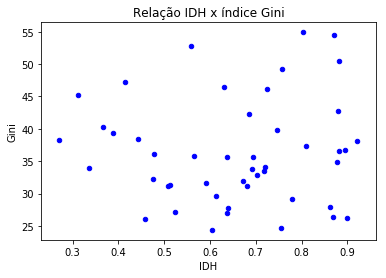

In [19]:
tabela.plot.scatter(x = "IDH", y = "Gini", color = 'b')
plt.title ('Relação IDH x índice Gini')

Vemos claramente no gráfico acima que não existe nenhuma correlação entre o IDH e o índice de desigualdade. Mas e quanto à possível correlação entre Gini e o PIB *per capta*?

Text(0.5,1,'Relação PIB x índice Gini')

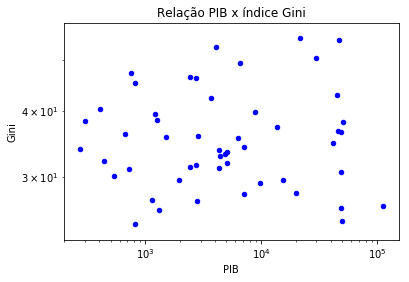

In [20]:
tabela.plot.scatter(x = "PIB", y = "Gini", loglog = True, color = 'b')
plt.title ('Relação PIB x índice Gini')

Essa correlação também é quase inexistênte, o que tira a conclusão possível de que um país rico é um país com igualdade social. 
Vamos agora levar em conta o índice S, dado por: $S = \frac{pibpercapta}{Gini}$, que mostra um pouco o quanto a desigualdade pode afetar no PIB *per capta* de um país e na sua relação com o IDH. Por exemplo: um país com Pib *per capta* 50000 e um índice Gini 50 (lembrando que quanto **maior** é o índice Gini, **mais** desigual o país é), terá o mesmo índice S que um país com o Pib *per capta* 10000 e índice Gini 10.

In [21]:
S = tabela.PIB/tabela.Gini.dropna()
tabela ['S'] = S

Uma vez criado o índice S, vamos ordenar os países por esse índice:

In [22]:
tabela.loc[:, ["País", "IDH", "S"]].sort_values(by = 'S').head(51)

,País,IDH,S
50,"Congo, Dem. Rep.",0.271,7.832898
75,Ethiopia,0.337,8.023599
141,Malawi,0.367,10.000000
140,Madagascar,0.476,13.540373
23,Benin,0.414,15.932203
72,Eritrea,NaN,17.674419
42,Chad,0.313,17.942478
18,Bangladesh,0.478,18.448753
35,Cambodia,0.508,23.344051
55,Cote d'Ivoire,0.388,30.710660


Text(0.5,1,'Relação IDH x índice S')

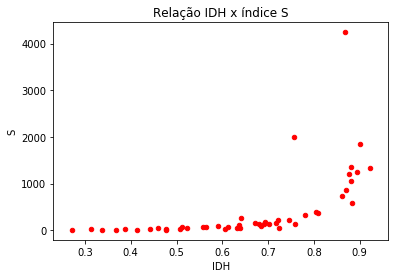

In [23]:
tabela.plot.scatter(x = "IDH", y = "S", color = 'r')
plt.title ('Relação IDH x índice S')

Podemos ver pelo gráfico que o índice S tem correlação com o IDH, de modo que quanto maior é o IDH maior é esse índice.

Ordenemos um resumo das conclusões parciais:

*Conclusão parcial 1:* Quanto mais desenvolvido um país é, maior a propensão a ter bilionários.



*Conclusão parcial 2:* O desenvolvimento de um país não está atrelado à falta de pobreza.

*Conclusão parcial 3:* Não há correlação entre o IDH/PIB *per capta* de um país e seu índice de desigualdade.


*Coclusão parcial 4:* Há correlação aparentemente exponencial entre o índice S e o IDH.

Levando em conta essas 4 conclusões parciais, pode ser analisada uma conclusão final: um país desenvolvido não é necessariamente um país sem pobreza, muito menos sem desigualdades. Pode-se dizer  que Um país rico tem propensão a ficar mais desenvolvido, uma vez que essa relação é direta: Embora não haja uma relação direta entre PIB e desigualdade, a forma com que a desigualdade afeta o PIB é crucial: nos países mais desenvolvidos, mesmo com uma desigualdade alta, há a tendência que a relação $\frac{Pib per capta}{desigualdade}$ é maior que nos países em desenvolvimento. Com isso, parece razoável concluir que as pessoas nesses países, tendo uma renda maior, mesmo que não completamente igualitária, estimulam mais a roda da economia, tornando possível a relação com o desenvolvimento, uma vez que a roda da economia gira: mais renda gera mais consumo, que gera mais fundos e impostos, o que gera mais emprego e conseguentemente um PIB per capta maior, influenciando-o.

O número de países com bilionários e o número de países com índice de pobreza $>0$ nos mostram essa relação: países mais ricos tendem a concentrar mais bilionários, porém não necessariamente seus índices de pobreza sejam menores: isso comprova a afirmação acima, uma vez que o IDH é calculado pegando como base somente a renda, não importando de quem é essa renda. Pode-se dizer, desse modo, que a questão de renda do IDH é desigual, uma vez que se levarmos em conta a maioria dos países desenvolvidos, quais possuem bilionários, a renda média é bastante afetada por estes, elevando assim, o critério renda no IDH, e com uma maior participação no PIB, visto que é muito provável que os bilionários consumam muito mais, elevando o PIB e consequentemente, o PIB *per capta*. 


Isso leva a uma questão reflexiva, baseada no fato de que se um país pode ser bem desenvolvido mesmo com uma tremenda desigualdade, tendo um número alto de Bilionários em ppm e também um grande número de pobres, esse desenvolvimento está beneficiando a totalidade da população?